In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# mnist dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

from dataset_tools import OwnDataset, make_train_test_val_split
from plotting import show_img, loss_plots, plot_random_images, plot_image_comparison, plot_latent
from collections import defaultdict


cuda = torch.cuda.is_available()
print(cuda)

True


# Data

In [2]:
val = True
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])
dataset = OwnDataset(transform=tf, path=r"C:\Users\Otto\Desktop\Fagprojekt_data\labelled_data")
# dataset = OwnDataset(transform=tf)
train_subset, test_subset, val_subset = make_train_test_val_split(dataset)




train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, pin_memory=cuda)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=True, pin_memory=cuda)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=True, pin_memory=cuda)

print(len(dataset), len(train_loader), len(test_loader), len(val_loader))

488396 4884 1527 1221


In [3]:
# # get breakdown of different classes present in the dataset
# class_count = defaultdict(int)
# for i in range(len(dataset)):
#     class_count[dataset[i][1]] += 1

In [4]:
# print(class_count.keys())
# # data_train.dataset.class_to_idx

# # plot
# plt.bar(class_count.keys(), class_count.values())

In [5]:
# class_count.keys()

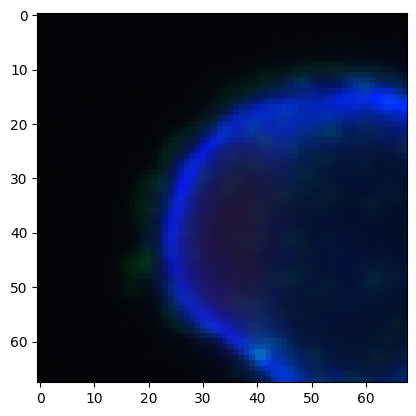

'Actin disruptors'

In [6]:
# get a sample image from the dataset
sample = dataset[612][0]
label = dataset[612][1]

# show the image
show_img(sample.view(3,68,68))

# moa
# data_train.dataset.class_to_idx
dataset.dataset.classes[label]


# Classifier

In [7]:
from models import CELL_CNN_CLASSIFIER, CELL_CNN_CLASSIFIER_2

model = CELL_CNN_CLASSIFIER(input_dim=(3, 68, 68), hidden_dim=128, num_classes=len(dataset.dataset.classes))
# model = CELL_CNN_CLASSIFIER_2(input_dim=(3, 68, 68), hidden_dim=128, num_classes=13)
print(model)

if cuda:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()


# number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')



CELL_CNN_CLASSIFIER(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=20736, out_features=128, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Linear(in_features=128, out_features=13, bias=True)
  )
)
The model has 3,044,429 trainable parameters


In [8]:
# test forward pass
x, y = next(iter(train_loader))
print(f"x.shape: {x.shape}")

if cuda:
    x = x.cuda()

output = model(x)
output.shape

x.shape: torch.Size([64, 3, 68, 68])


torch.Size([64, 13])

In [9]:
# define dirs for the saving of model / data
MODEL_NAME = f"{model.__class__.__name__}_"
MODEL_DIR = "trained_models/"
TRAIN_DATA_DIR = "train_data/"

print(MODEL_NAME)


CELL_CNN_CLASSIFIER_


In [10]:
num_epochs = 50
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
best_loss = np.inf

for epoch in range(num_epochs):
    batch_loss = []
    batch_accuracy = []
    model.train()

    for x, y in train_loader:
        if cuda:
            x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        output = model(x)
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())
        batch_accuracy.append((output.argmax(1) == y).float().mean().item())

    train_loss.append(np.mean(batch_loss))
    train_accuracy.append(np.mean(batch_accuracy))
    if val:
        model.eval()
        with torch.no_grad():
            batch_loss = []
            batch_accuracy = []
            for x, y in val_loader:
                if cuda:
                    x, y = x.cuda(), y.cuda()

                output = model(x)
                loss = loss_function(output, y)

                batch_loss.append(loss.item())
                batch_accuracy.append((output.argmax(1) == y).float().mean().item())

            val_loss.append(np.mean(batch_loss))
            val_accuracy.append(np.mean(batch_accuracy))

            if val_loss[-1] < best_loss:
                best_loss = val_loss[-1]
                torch.save(model.state_dict(), MODEL_DIR + MODEL_NAME + "best_model.pth")

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss[-1]}, Accuracy: {train_accuracy[-1]}, Val Loss: {val_loss[-1] if val else None}, Val Accuracy: {val_accuracy[-1] if val else None}")

Epoch 1/50, Loss: 0.8204292749938762, Accuracy: 0.7462995666120665, Val Loss: 0.6908568402570745, Val Accuracy: 0.7811476248976249
Epoch 2/50, Loss: 0.6286704922544966, Accuracy: 0.7986264673764674, Val Loss: 0.6289578901998925, Val Accuracy: 0.7954801392301393
Epoch 3/50, Loss: 0.5410477071969994, Accuracy: 0.8221966284466284, Val Loss: 0.6085965486333372, Val Accuracy: 0.8014050982800983
Epoch 4/50, Loss: 0.4673347670270662, Accuracy: 0.8424238158613159, Val Loss: 0.5944746705496731, Val Accuracy: 0.8115658271908271
Epoch 5/50, Loss: 0.39675105441846775, Accuracy: 0.8634241485803986, Val Loss: 0.6505286867847021, Val Accuracy: 0.8021345208845209
Epoch 6/50, Loss: 0.3334185807316592, Accuracy: 0.8831471386158886, Val Loss: 0.6907461678684002, Val Accuracy: 0.807713963963964
Epoch 7/50, Loss: 0.2742990449125849, Accuracy: 0.9020415301665301, Val Loss: 0.795503208497623, Val Accuracy: 0.8002021908271908
Epoch 8/50, Loss: 0.2311254647426173, Accuracy: 0.9169985326235326, Val Loss: 0.8803

# Evaluate performance on test set

In [17]:
test_loss = []
test_accuracy = []

model.eval()

with torch.no_grad():
    for x, y in test_loader:
        if cuda:
            x, y = x.cuda(), y.cuda()

        output = model(x)
        loss = loss_function(output, y)

        test_loss.append(loss.item())
        test_accuracy.append((output.argmax(1) == y).cpu().numpy().mean())
    
    print(f"Test Loss: {np.mean(test_loss)}, Test Accuracy: {np.mean(test_accuracy)}")

Test Loss: 3.012038831080029, Test Accuracy: 0.7880239030779306


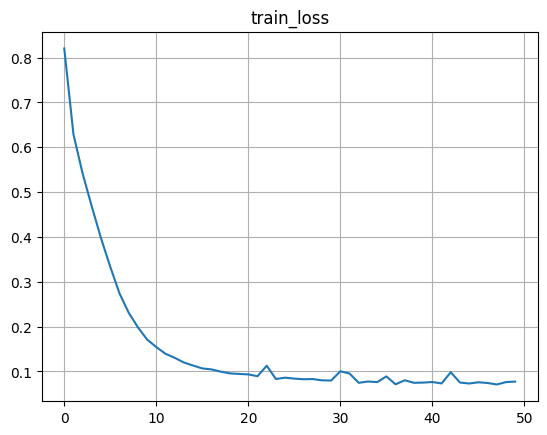

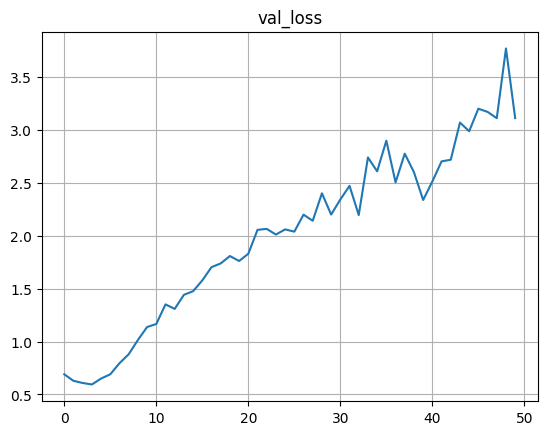

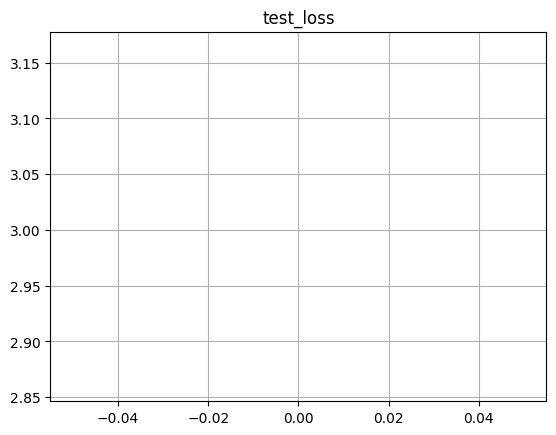

In [18]:
# make a dictionary with the losses as keys and the values as lists
loss_data = {}
loss_data["train_loss"] = train_loss
loss_data["val_loss"] = val_loss
loss_data["test_loss"] = np.mean(test_loss)

accuracy_data = {}
accuracy_data["train_accuracy"] = train_accuracy
accuracy_data["val_accuracy"] = val_accuracy
accuracy_data["test_accuracy"] = np.mean(test_accuracy)

loss_plots(loss_data, invidual_plots=True)
# accuracy_plots(accuracy_data)

# combine to one dict
data = loss_data | accuracy_data

# save the data
df = pd.DataFrame(data)
try:
    old_df = pd.read_csv(TRAIN_DATA_DIR + MODEL_NAME + "data.csv")
    df = pd.concat([old_df, df])
except:
    pass
df.to_csv(TRAIN_DATA_DIR + MODEL_NAME + "data.csv", index=False)


## Test model

In [12]:
# test model on test data
model.eval()
test_accuracy = []
for x, y in test_loader:
    if cuda:
        x, y = x.cuda(), y.cuda()

    with torch.no_grad():
        output = model(x)
        test_accuracy.append((output.argmax(1) == y).float().mean().item())

print(f"Test accuracy: {np.mean(test_accuracy)}")



Test accuracy: 0.7880239030779306


In [14]:
# calculate prediction accuracy for each class
class_correct = defaultdict(int)
class_total = defaultdict(int)

model.eval()

for x, y in test_loader:
    if cuda:
        x, y = x.cuda(), y.cuda()

    with torch.no_grad():
        output = model(x)
        correct = (output.argmax(1) == y).float()

        for i in range(len(y)):
            label = y[i].item()
            class_correct[label] += correct[i].item()
            class_total[label] += 1


In [15]:
class_accuracies = {k: class_correct[k] / class_total[k] for k in class_correct.keys()}

for i in range(len(class_accuracies)):
    print(f"Accuracy for class {dataset.dataset.classes[i]}: {class_accuracies[i]}")



Accuracy for class Actin disruptors: 0.7968021319120586
Accuracy for class Aurora kinase inhibitors: 0.6268833087149187
Accuracy for class Cholesterol-lowering: 0.3912231559290383
Accuracy for class DMSO: 0.9066722057654794
Accuracy for class DNA damage: 0.2020414290003002
Accuracy for class DNA replication: 0.24547101449275363
Accuracy for class Eg5 inhibitors: 0.5670347003154574
Accuracy for class Epithelial: 0.3466981132075472
Accuracy for class Kinase inhibitors: 0.13200173686495875
Accuracy for class Microtubule destabilizers: 0.5648208469055375
Accuracy for class Microtubule stabilizers: 0.905575791538246
Accuracy for class Protein degradation: 0.23567393058918482
Accuracy for class Protein synthesis: 0.5781966377992868


In [16]:
import plotly.express as px

# bar plot of class accuracies
fig = px.bar(x=[dataset.dataset.classes[i] for i in class_accuracies.keys()], y=list(class_accuracies.values()))
fig.show()